# Model Evaluation
Part 2

In [83]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pingouin as pg
from scipy.stats import zscore

In [72]:
file_path = 'data/dataset.csv'
df = pd.read_csv(file_path, sep=';', header=0)

In [73]:
unique_competitions = df['Competition'].unique()
print("Unique Competition classes:", unique_competitions)
competition_counts = df['Competition'].value_counts()
print("Distribution of Competition classes:")
print(competition_counts)

Unique Competition classes: ['U14' 'U16' 'NBA' 'SLO1' 'EURO']
Distribution of Competition classes:
Competition
EURO    1371
NBA     1228
SLO1    1182
U14      738
U16      505
Name: count, dtype: int64


### Results from part 1

In [74]:
# The cross-validated accuracy and log-loss results are estimates of the empirical risk for each model. These are based on the observed data distribution.

with open('all_model_results.pkl', 'rb') as f:
    data = pickle.load(f)

In [75]:
y_true = data['y_true']
y_pred_baseline = data['y_pred_baseline']
y_pred_lr = data['y_pred_lr']
y_pred_rf1 = data['y_pred_rf1']
y_pred_rf2 = data['y_pred_rf2']
distance_test = df.loc[data['test_indices'], 'Distance'].values
distances = df['Distance'].values


## Statistical Analysis

In [86]:
# Q: Is the data normally distributed?

numerical_data = df.select_dtypes(include=['float64', 'int64'])

# Standardize
numerical_data = numerical_data.apply(zscore)

# Henze-Zirkler (HZ) Test for numerical features
hz_test = pg.multivariate_normality(numerical_data)
print("Henze-Zirkler Test:\n", hz_test)

Henze-Zirkler Test:
 HZResults(hz=239.51118142608158, pval=0.0, normal=False)


### First, we suspect that error depends on Distance. 
Provide further results that confirm (or disprove) our suspicions. Describe and motivate your methodology.

In [6]:
# Q: Are the prediction errors correlated with the Distance feature? Do models make more errors from certain distances?

# Step 1: Get the errors
errors_baseline = data['errors_baseline']
errors_lr = data['errors_lr']
errors_rf1 = data['errors_rf1']
errors_rf2 = data['errors_rf2']

#### Bin the Distance Values

In [23]:
min_distance = distances.min()
max_distance = distances.max()
bins = np.linspace(min_distance, max_distance, num=7)  # creates 7 equally spaced values between min and max => 6 bins
print("Bins:", bins)
bin_labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
print("Bin Labels:", bin_labels)
# Bin the distance values
distance_bins = pd.cut(distances, bins=bins, labels=bin_labels) # returns a Categorical object -> replaces each distance value with the corresponding bin label

Bins: [0.04       1.69166667 3.34333333 4.995      6.64666667 8.29833333
 9.95      ]
Bin Labels: ['0-1', '1-3', '3-4', '4-6', '6-8', '8-9']


In [34]:
# Get the percentage of each bin in distance_bins
distance_bin_percentages = distance_bins.value_counts() / len(distance_bins) * 100
print("Distance Bin Percentages:\n", distance_bin_percentages)

Distance Bin Percentages:
 0-1    36.863057
1-3    12.977707
3-4     8.240446
4-6    11.285828
6-8    29.996019
8-9     0.617038
Name: count, dtype: float64


#### Calculate the Error Rates

In [65]:
distance_bins_test = pd.cut(distance_test, bins=bins, labels=bin_labels)
print("Distance Bins (Test Set):")
distance_bin_tsp = distance_bins_test.value_counts() / len(distance_bins_test) * 100
print(distance_bin_tsp)

Distance Bins (Test Set):
0-1    37.135279
1-3    14.588859
3-4     8.222812
4-6    10.610080
6-8    28.912467
8-9     0.530504
Name: count, dtype: float64


In [68]:
import pandas as pd

def calculate_misclassification_rate(y_true, y_pred, distance_bins):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'distance_bins': distance_bins})
    # determine the average proportion of incorrect predictions within each distance bin
    misclassification_rate = df.groupby('distance_bins', observed=True).apply(lambda x: (x['y_true'] != x['y_pred']).mean())
    return misclassification_rate

# Calculate misclassification rates for each model
misclassification_rate_baseline = calculate_misclassification_rate(y_true, y_pred_baseline, distance_bins_test)
misclassification_rate_lr = calculate_misclassification_rate(y_true, y_pred_lr, distance_bins_test)
misclassification_rate_rf1 = calculate_misclassification_rate(y_true, y_pred_rf1, distance_bins_test)
misclassification_rate_rf2 = calculate_misclassification_rate(y_true, y_pred_rf2, distance_bins_test)

# Calculate error rates - These rates provide a weighted measure of misclassification, considering the distribution of data points across distance bins. This helps in understanding the overall impact of distance on model performance.
error_rates_baseline = misclassification_rate_baseline * distance_bin_tsp
error_rates_lr = misclassification_rate_lr * distance_bin_tsp
error_rates_rf1 = misclassification_rate_rf1 * distance_bin_tsp
error_rates_rf2 = misclassification_rate_rf2 * distance_bin_tsp

# Print the error rates
print("Error Rates (Baseline):")
print(error_rates_baseline)
print("Error Rates (Logistic Regression):")
print(error_rates_lr)
print("Error Rates (Random Forest 1):")
print(error_rates_rf1)
print("Error Rates (Random Forest 2):")
print(error_rates_rf2)

Error Rates (Baseline):
distance_bins
0-1    29.509284
1-3     7.360743
3-4     1.061008
4-6     0.331565
6-8     1.657825
8-9     0.066313
dtype: float64
Error Rates (Logistic Regression):
distance_bins
0-1    16.511936
1-3     6.233422
3-4     0.928382
4-6     0.331565
6-8     1.657825
8-9     0.066313
dtype: float64
Error Rates (Random Forest 1):
distance_bins
0-1    15.848806
1-3     4.111406
3-4     0.663130
4-6     0.331565
6-8     1.591512
8-9     0.000000
dtype: float64
Error Rates (Random Forest 2):
distance_bins
0-1    15.649867
1-3     4.111406
3-4     0.663130
4-6     0.331565
6-8     1.591512
8-9     0.000000
dtype: float64


C:\Users\Teodora\AppData\Local\Temp\ipykernel_23792\3362080020.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  misclassification_rate = df.groupby('distance_bins', observed=True).apply(lambda x: (x['y_true'] != x['y_pred']).mean())
C:\Users\Teodora\AppData\Local\Temp\ipykernel_23792\3362080020.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  misclassification_rate = df.groupby('distance_bins', observ

NOTE: Having an error rate of 29 for the distance bin 0-1, means that within this specific distance range, 29% of the predictions made by the model are incorrect. This indicates that the model has a relatively high misclassification rate for data points that fall within the 0-1 distance bin, suggesting that the model struggles to make accurate predictions for this particular range of distances

#### Visualize the Relationship

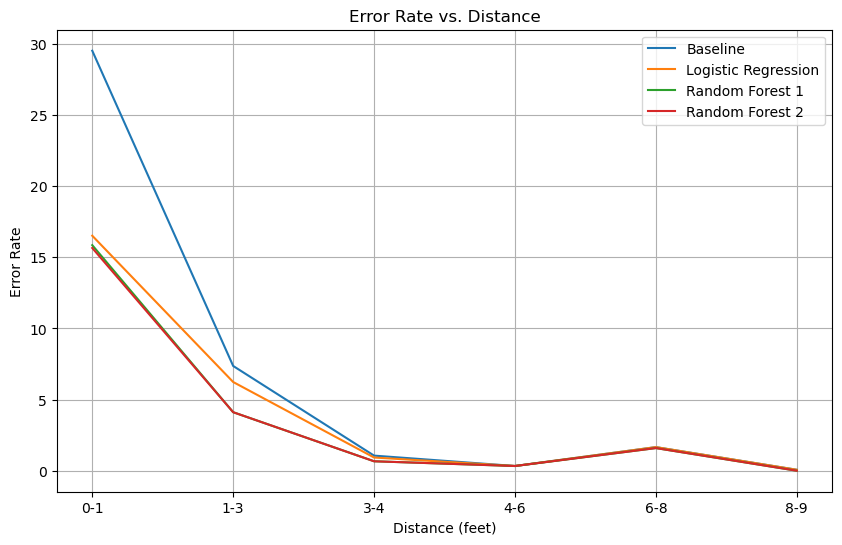

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(error_rates_baseline.index, error_rates_baseline, label='Baseline')
plt.plot(error_rates_lr.index, error_rates_lr, label='Logistic Regression')
plt.plot(error_rates_rf1.index, error_rates_rf1, label='Random Forest 1')
plt.plot(error_rates_rf2.index, error_rates_rf2, label='Random Forest 2')
plt.xlabel('Distance (feet)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Distance')
plt.legend()
plt.grid(True)
plt.show()

#### Statistical Analysis
Correlation Analysis

In [91]:
print("Baseline:")
spearman_corr, _ = spearmanr(errors_baseline, distance_test)
print(f"Spearman correlation: {spearman_corr}, p-value: {_}")

Baseline:
Spearman correlation: -0.6583047995009514, p-value: 5.388770561405651e-188


In [92]:
print("Logistic Regression:")
spearman_corr, _ = spearmanr(data["errors_lr"], distance_test)
print(f"Spearman correlation: {spearman_corr}, p-value: {_}")

Logistic Regression:
Spearman correlation: -0.36502479817937655, p-value: 9.670542889127037e-49


In [93]:
print("Random Forest (Flat CV):")
spearman_corr, _ = spearmanr(data["errors_rf1"], distance_test)
print(f"Spearman correlation: {spearman_corr}, p-value: {_}")

Random Forest (Flat CV):
Spearman correlation: -0.3511856164147009, p-value: 5.254284862712921e-45


In [94]:
print("Random Forest (Nested CV):")
spearman_corr, _ = spearmanr(data["errors_rf2"], distance_test)
print(f"Spearman correlation: {spearman_corr}, p-value: {_}")

Random Forest (Nested CV):
Spearman correlation: -0.34578041271710896, p-value: 1.3472934395539037e-43


### Second, it turns out that the dataset is not entirely representative of the data generating process.
The difference is that the true relative frequencies of Competition types are 0.6 for
NBA and 0.1 for the other four types (instead of the approximately equal representation of
types in the given dataset). Estimate how the models would perform on data with the true
relative frequencies of Competition type. Report the results and your interpretation. Describe
and motivate your methodology.

In [ ]:
# Q: How would the models perform on data with the true relative frequencies of Competition type?
# TODO: Estimate how the models would perform on data with the true relative frequencies of Competition type.
